# 04.02 - DATA CLEANING

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()


## Based on [Kaggle House Pricing Prediction Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/)

- Inspect and learn from the competition [Notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks)
- You must make available to this notebook the `train.csv` file from the competition [data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) section. If running this notebook in Google Colab you must upload it in the notebook files section in Colab.

In [176]:
## KEEPOUTPUT
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from progressbar import progressbar as pbar
from local.lib import mlutils
%matplotlib inline
d = pd.read_csv("train.csv", index_col="Id")
d.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [178]:
## KEEPOUTPUT
print (d.shape)

(1460, 80)


## We must repair the missing data in the following columns

**Possible repair actions**:

- Remove row or column
- Replace value (why what?)

In [179]:
## KEEPOUTPUT
k = d.isna().sum()
k[k!=0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

### Inspect and understand missing data

In [180]:
## KEEPOUTPUT
def plot_missing(col, target):
    
    def f1(): 
        if d[col].dtype==object:
            k = d[col].fillna("missing").value_counts()
            sns.barplot(k.index, k.values)
        else:
            sns.distplot(d[col].dropna())
        plt.title("distribution of %s"%col)
        plt.grid()
        
    def f2(): 
        if d[col].dtype==object:
            k=d[[col,target]].dropna()
            for v in d[col].dropna().unique():
                if sum(k[col]==v)>1:
                    sns.distplot(k[target][k[col]==v], 
                                 hist_kws=dict(alpha=.3), 
                                 kde_kws=dict(linewidth=1, alpha=.8),
                                 label=v);
            if sum(d[col].isna())>1:
                sns.distplot(d[target][d[col].isna()], 
                             hist_kws=dict(alpha=.8), 
                             kde_kws=dict(linewidth=1, alpha=1),
                             label="missing")
            plt.legend();
        else:
            plt.scatter(d[col], d[target], alpha=.5)
            plt.xlabel(target)
            plt.ylabel(col)
        plt.grid()
        plt.title("%s vs target"%(col))
        
    def f3(): 
        n = np.sum(d[col].isna())
        if n>1:
            sns.distplot(d[target][d[col].isna()], color="red",  hist_kws=dict(alpha=.3), label="missing (%d values)"%n)
        sns.distplot(d[target][~d[col].isna()], color="blue",  hist_kws=dict(alpha=.3), label="ok (%d values)"%(len(d)-n))
        plt.title("distribution of target wrt %s"%col)
        plt.yticks([])
        plt.grid()
        plt.legend()
        
    mlutils.figures_grid(3,1, [f1, f2, f3], figsize=(20,3))


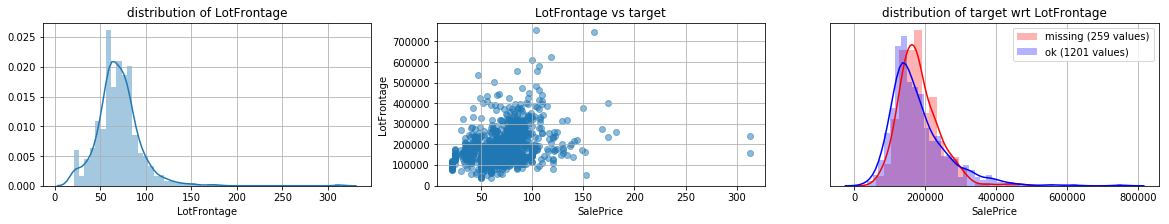

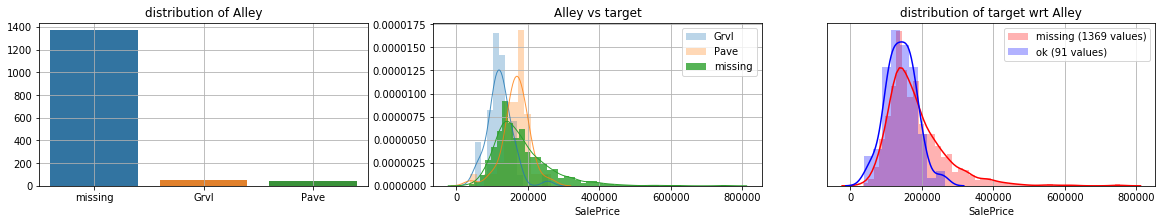

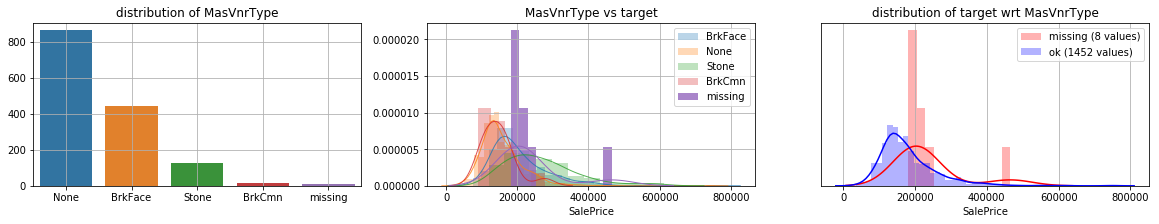

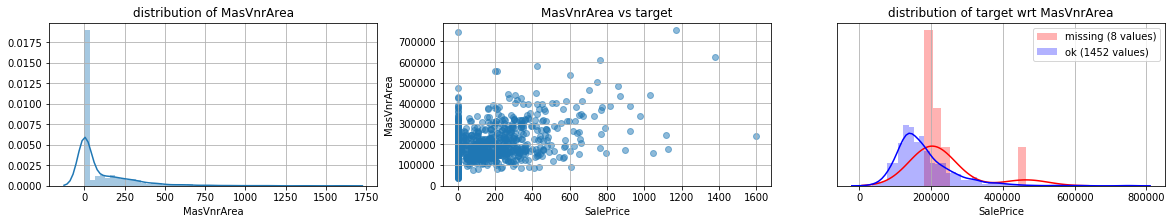

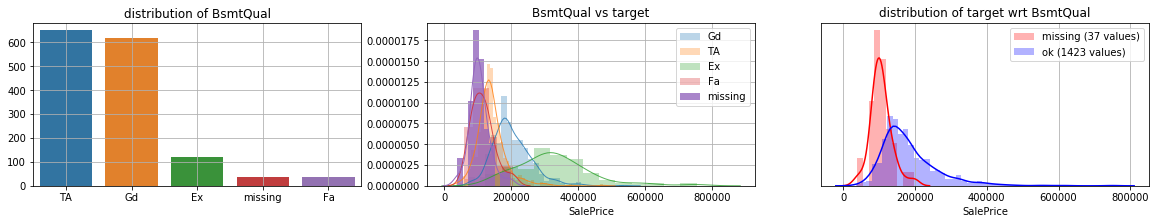

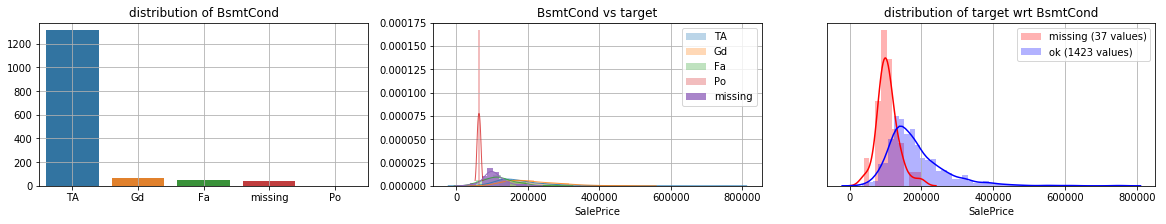

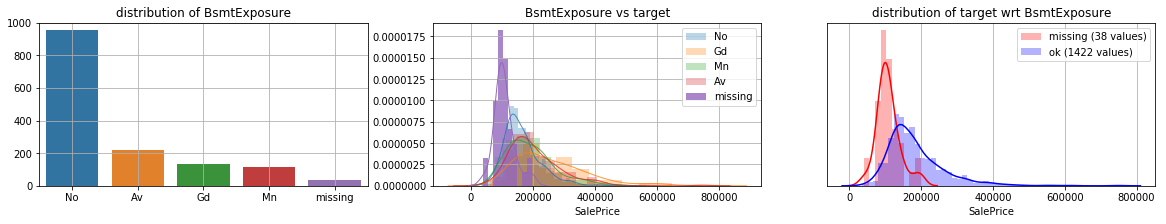

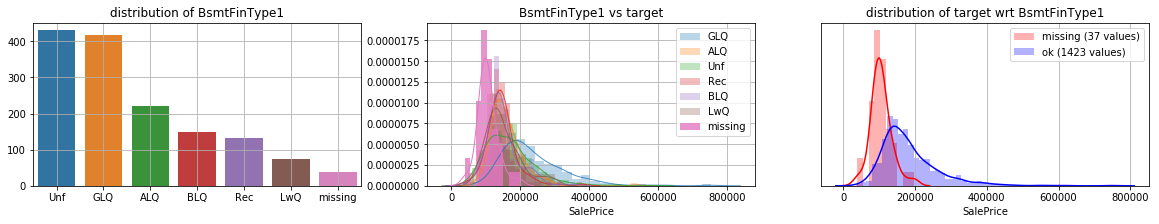

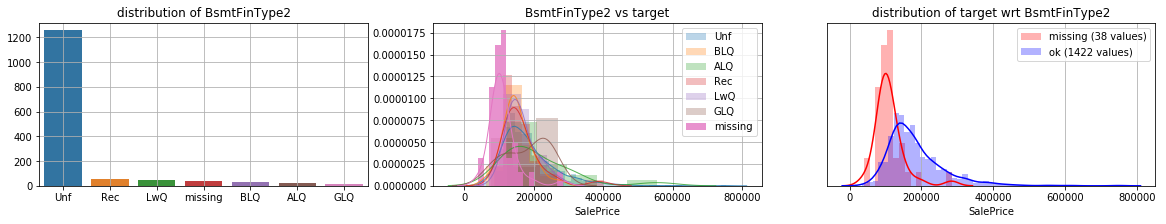

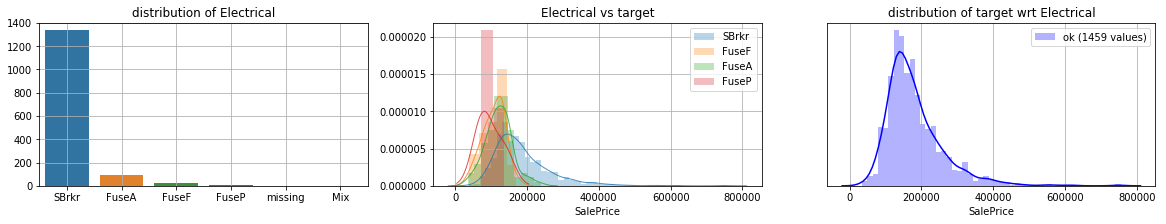

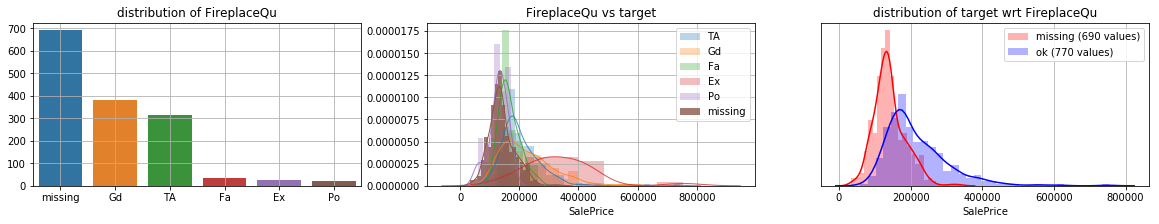

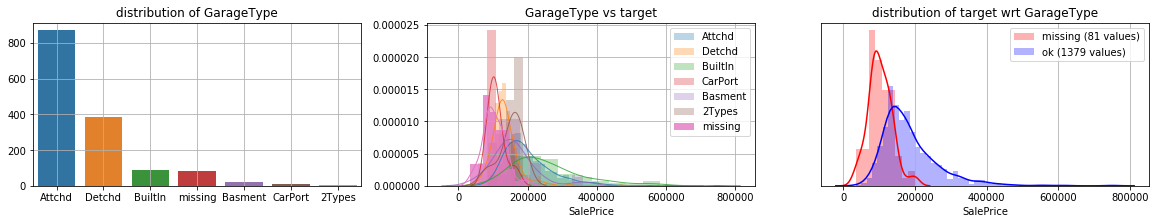

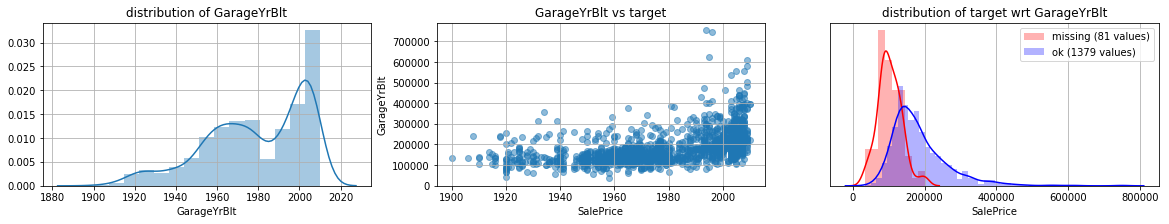

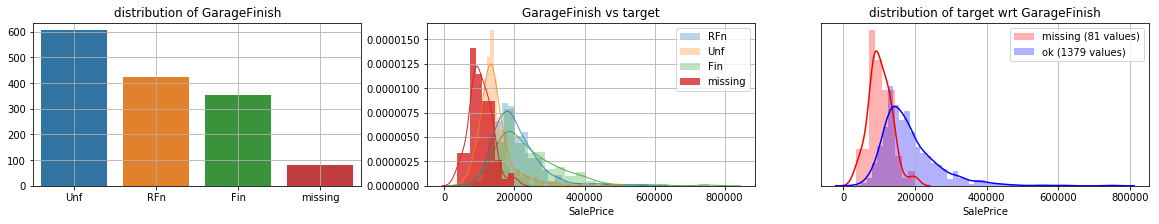

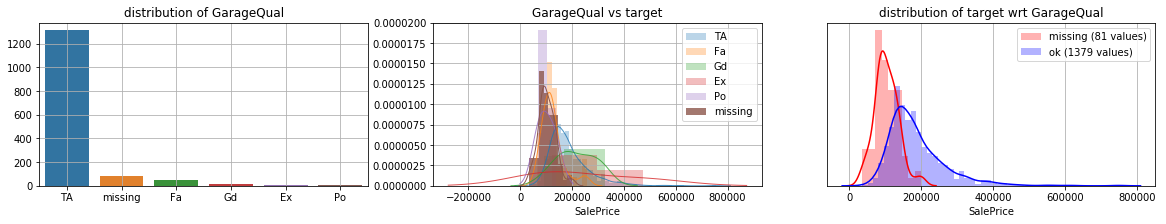

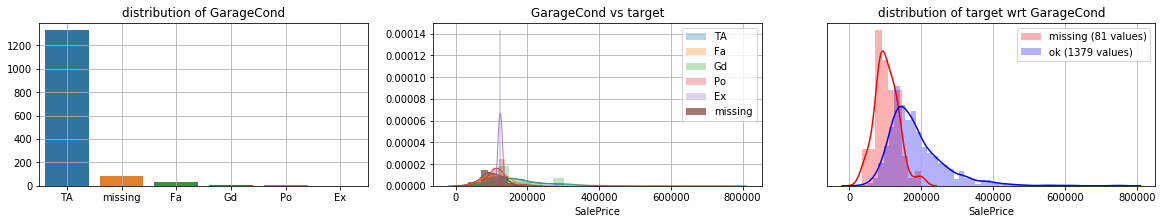

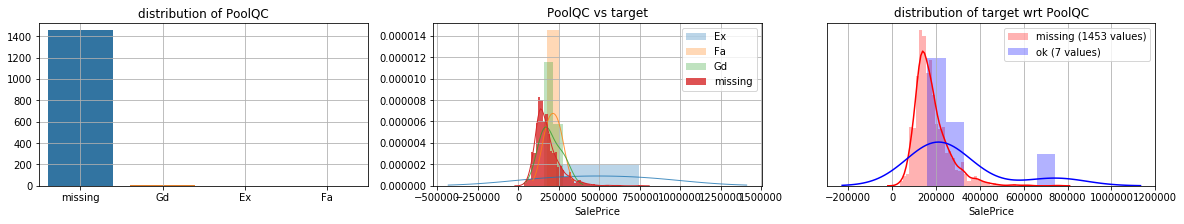

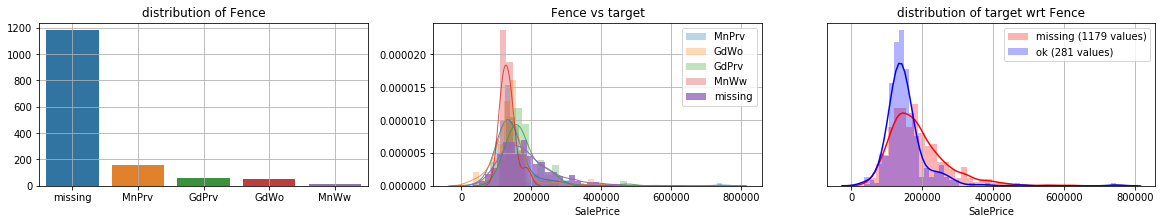

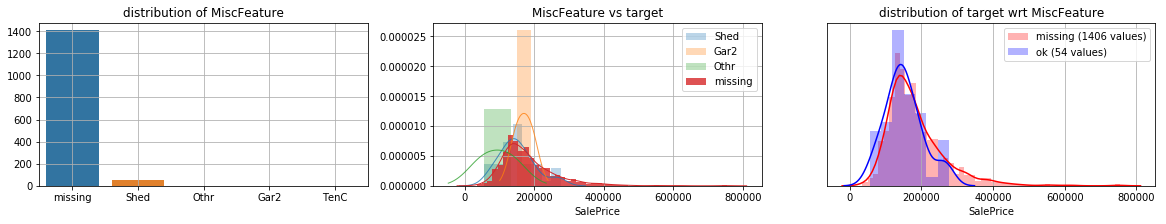

In [181]:
## KEEPOUTPUT
for col in k[k!=0].index:
    plot_missing(col, target="SalePrice")

### common sense

- too many missing data in **Alley**. Information might only help non-missing items with little impact on
- missing data in **Bsmt\*** seem all the same
- missing data in **Garage\*** sell all the same

## For continuous variables

### Three substitution techniques

- by a fixed value (zero)
- by a fixed value (the mean)
- sampling from an equivalent normal (same mean and std)

**First** we create the different datasets:

- `dn`: original data only with numerical attributes
- `dl0`: substituting missing values with zero
- `dlm`: substituting missing values with the mean
- `dlr`: substituting missing values with an equivalent normal (same mean and stdev)

In [182]:
def xdistplot(k, title="", xlim=None):
    vals = k
    sns.distplot(k, hist_kws={"alpha": .8});
    m,s = np.mean(vals), np.std(vals)
    plt.axvline(m, color="black", lw=2, alpha=.5)
    plt.axvline(m+s, color="red", lw=2, alpha=.5)
    plt.axvline(m-s, color="red", lw=2, alpha=.5)
    x = np.linspace(np.min(vals), np.max(vals), 100)
    plt.title(title)
    plt.grid();
    if xlim is not None:
        plt.xlim(xlim)

In [316]:
def subs_policies(d, col):
    mcol = "%s_missing"%col
    dn = d.T.dropna().T
    dn = dn[[i for i in dn.columns if d[i].dtype!=object]]
    print (dn.shape)
    
    na_idxs = np.argwhere(d[col].isna().values)[:,0]

    dl0 = dn.copy()
    dlm = dn.copy()
    dlr = dn.copy()

    dl0[mcol] = d[col].fillna(0)
    dlm[mcol] = d[col].fillna( d[col].mean())

    k = d[col].copy()
    k[k.isna()] = np.random.normal(loc=np.mean(k), scale=np.std(k), size=np.sum(k.isna()))
    dlr[mcol] = k

    f0 = lambda: xdistplot(d[col].dropna(), "original", [0,150])
    f1 = lambda: xdistplot(dl0[mcol], "subs by zero", [0,150])
    f2 = lambda: xdistplot(dlm[mcol], "subs by mean", [0,150])
    f3 = lambda: xdistplot(dlr[mcol], "subs by equivalent normal", [0,150])

    mlutils.figures_grid(4,1, [f0, f1, f2, f3], figsize=(20,3))
    return dn, dl0, dlm, dlr, na_idxs

(1460, 34)


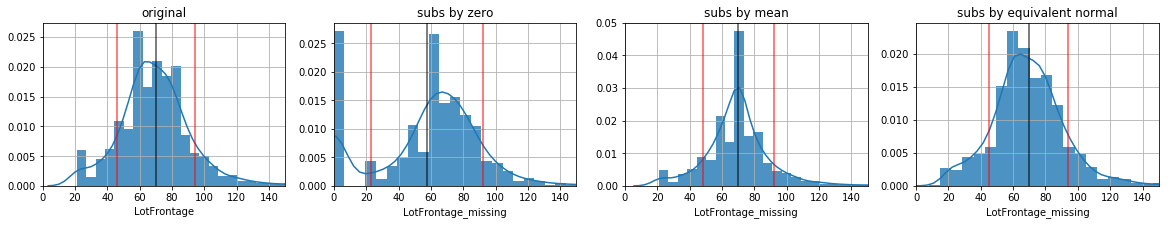

In [317]:
## KEEPOUTPUT
dn, dl0, dlm, dlr, na_idxs = subs_policies(d, "LotFrontage")

### Validation workflow for repairing missing values on **LotFrontage**

**Which policy for repairing missing data is best?**

Short answer: **we do not know** $\rightarrow$ **we must seek evidence**

We will now integrate them in an ML workflow, creating predictive models and seeking for evidence if models improve or not when using different policies for repairing missing data.

We train a lot of models (resampling training data) with each dataset and then run a classical hypothesis test on model performance:
    
- $e_1$: control group, models trained without **LotFrontage**
- $e_2$: population group, models trained with **LotFrontage** with fillna=0

Our null hypothesis (there is no effect in using the new variable):

$$H_0: \mu_{e_1}-\mu_{e_2}=0 \Rightarrow \mu_{e_1-e_2}=0$$

Our test hypothesis (including fillna=0 improves models):

$$H_1: \mu_{e_1}-\mu_{e_2}<0 \Rightarrow \mu_{e_1-e_2}<0$$


In [393]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import ttest_ind

def getXY (dn):
    xcols = [i for i in dn.columns if i!="SalePrice"]
    X = dn[xcols].values.astype(float)
    y = dn.SalePrice.values.astype(float)
    return X,y,xcols

def experiment(dn, estimator, n_models=20, test_size=.3):
    X,y,_ = getXY(dn)
    r = cross_val_score(estimator, X, y, cv=ShuffleSplit(n_models, test_size=test_size), 
                        scoring=make_scorer(mean_absolute_error))
    return r

def HTest(ref_dataset, h_datasets, n_models=30, experiment=experiment, **kwargs):
    estimator = RandomForestRegressor(n_estimators=20)
    re = [experiment(i, estimator, n_models=n_models, **kwargs) for i in pbar([ref_dataset]+h_datasets)]

    for r in re[1:]:
        print (ttest_ind(re[0],r))


In [383]:
## KEEPOUTPUT
dl0.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,LotFrontage_missing
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,0,150,856,...,61,0,0,0,0,0,2,2008,208500,65.0
2,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,0,0,0,5,2007,181500,80.0
3,60,11250,7,5,2001,2002,486,0,434,920,...,42,0,0,0,0,0,9,2008,223500,68.0
4,70,9550,7,5,1915,1970,216,0,540,756,...,35,272,0,0,0,0,2,2006,140000,60.0
5,60,14260,8,5,2000,2000,655,0,490,1145,...,84,0,0,0,0,0,12,2008,250000,84.0


In [408]:
## KEEPOUTPUT
HTest(dn, [dl0, dlm, dlr], n_models=50)

100% (4 of 4) |##########################| Elapsed Time: 0:00:22 Time:  0:00:22


Ttest_indResult(statistic=0.7557691502516851, pvalue=0.4516003896675306)
Ttest_indResult(statistic=-1.4073818287584146, pvalue=0.1624780543324849)
Ttest_indResult(statistic=-0.38678169914375066, pvalue=0.6997564158414822)


In [409]:
## KEEPOUTPUT
HTest(dn, [dl0, dlm, dlr], n_models=50)

100% (4 of 4) |##########################| Elapsed Time: 0:00:22 Time:  0:00:22


Ttest_indResult(statistic=-0.2674687679580992, pvalue=0.7896703521077283)
Ttest_indResult(statistic=0.07436389268867344, pvalue=0.9408724204351284)
Ttest_indResult(statistic=1.1275786355848136, pvalue=0.26225106743094523)


No $p$ value is really significative so the different substitution policies do no help improve overall in this simplified setting. More over, repeated experiments show to evidence of any approach better than others (always better $p$ value)

Some models provide us with a measure of **feature importance**. Observe the behaviour of the most important variables in the scatter matrix plot of previous notebook.

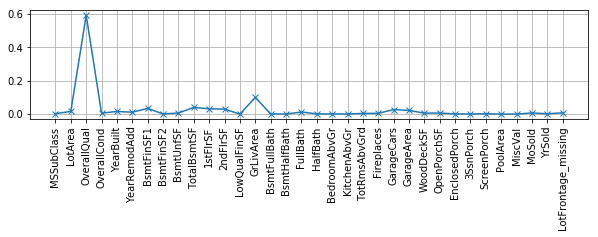

In [416]:
## KEEPOUTPUT
X, y, xcols = getXY(dlr)
rf = RandomForestRegressor(n_estimators=20)
rf.fit(X,y);
plt.figure(figsize=(10,2)); plt.grid()
plt.plot(rf.feature_importances_, label="est1", marker="x")
plt.xticks(range(len(xcols)), xcols, rotation="vertical");

so somehow it is understandable that providing values for this missing variable does not have so much impact.

We could try to see **ONLY** how records with **THIS** missing data behave. Observe that `na_idxs` marks which rows contain `na` values so that they are used to measure validation performance. 

There is still no clear evidence that any filling strategy for missing values  is better than other.

In [394]:
def na_cross_val_score(estimator, X, y, cv, scoring, val_idxs):
    r = []
    for tr_idxs, ts_idxs in cv.split(X):
        tr_idxs, ts_idxs = np.r_[tr_idxs], np.r_[ts_idxs]
        rf.fit(X[tr_idxs], y[tr_idxs])
        valts_idxs = np.r_[[i for i in ts_idxs if i in val_idxs]]
        r.append(scoring(rf, X[valts_idxs], y[valts_idxs]))    
    return r


def na_experiment(dn, estimator, na_idxs, n_models=20, test_size=.3):
    X,y,_ = getXY(dn)
    r = na_cross_val_score(estimator, X, y, cv=ShuffleSplit(n_models, test_size=test_size), 
                        scoring=make_scorer(mean_absolute_error), val_idxs=na_idxs)
    return r


In [406]:
## KEEPOUTPUT
HTest(dn, [dl0, dlm, dlr], experiment=na_experiment, na_idxs=na_idxs, n_models=50)

100% (4 of 4) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11


Ttest_indResult(statistic=-0.5737783622358789, pvalue=0.5674323034918392)
Ttest_indResult(statistic=-0.9266853946811004, pvalue=0.3563664656955138)
Ttest_indResult(statistic=1.871355121426504, pvalue=0.06427879742818265)


In [407]:
HTest(dn, [dl0, dlm, dlr], experiment=na_experiment, na_idxs=na_idxs, n_models=50)

100% (4 of 4) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11


Ttest_indResult(statistic=-0.8579704279579935, pvalue=0.3930022714114304)
Ttest_indResult(statistic=-0.4420684947642289, pvalue=0.6594136691363447)
Ttest_indResult(statistic=1.163369779223683, pvalue=0.24750430665847803)


## For categorical features

- we must convert them to numerical
    - if categories are **ordered** $\rightarrow$ convert to positive integer
    - otherwise $\rightarrow$ convert to one hot
- we must decide on missing values:
    - remove row or column
    - assign an existing value
    - assign a new value

In [334]:
## KEEPOUTPUT
col = "GarageFinish"
print ("missing", sum(d[col].isna()))
d[col].value_counts()

missing 81


Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [364]:
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_column_with_onehot(d, col):
    assert sum(d[col].isna())==0, "column must have no NaN values"
    values = np.unique(d[col]
                      )
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%s"%(col, values[i]) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

observe **onehot** encoding

In [365]:
## KEEPOUTPUT
d[[col]].head(10)

,GarageFinish
Id,
1,RFn
2,RFn
3,RFn
4,Unf
5,RFn
6,Unf
7,RFn
8,RFn
9,Unf


In [366]:
## KEEPOUTPUT
replace_column_with_onehot(d[[col]].dropna().copy(), col).head(10)

,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
Id,,,
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
5,0,1,0
6,0,0,1
7,0,1,0
8,0,1,0
9,0,0,1


we now create a onehot encoding for each case:
- create a separate value for missing data
- set missing data to an existing category. In this case we will set it to the closest category distribution wrt the target variable according the plots above

In [367]:
## KEEPOUTPUT
rm1 = replace_column_with_onehot(d[[col]].fillna("missing").copy(), col)
rm2 = replace_column_with_onehot(d[[col]].fillna("Unf").copy(), col)

In [368]:
## KEEPOUTPUT
rm1.head()

,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_missing
Id,,,,
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0
5,0,1,0,0


In [369]:
## KEEPOUTPUT
rm2.head()

,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
Id,,,
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
5,0,1,0


In [391]:
## KEEPOUTPUT
dm1 = dn.join(rm1)
dm2 = dn.join(rm2)
dm1.shape, dm2.shape

((1460, 38), (1460, 37))

again, do hypothesis testing to seek for evidence for improvements for any of the methods

In [410]:
## KEEPOUTPUT
HTest(dn, [dm1, dm2], experiment=experiment, n_models=50)

100% (3 of 3) |##########################| Elapsed Time: 0:00:16 Time:  0:00:16


Ttest_indResult(statistic=0.20678743729250315, pvalue=0.8366049088865752)
Ttest_indResult(statistic=2.3425479620420515, pvalue=0.021174779349792214)


In [412]:
## KEEPOUTPUT
na_idxs = np.argwhere(d[col].isna().values)[:,0]
HTest(dn, [dm1, dm2], experiment=na_experiment, na_idxs=na_idxs, n_models=50)

100% (3 of 3) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08


Ttest_indResult(statistic=0.27587786417000965, pvalue=0.7832227828661817)
Ttest_indResult(statistic=1.2880901521198285, pvalue=0.2007476881215529)


Again, no $p$ value is sufficiently significative to provide evidence for improved classification alone. However, approach number 2 (substituting missing data with **Unf**) does seem to consistently get better $p$ value and, thus, more chance to improve performance when combined with other data cleaning choices. 

Observe also how the **missing** category dilutes the importance of **Unf** after other variables are taken out.

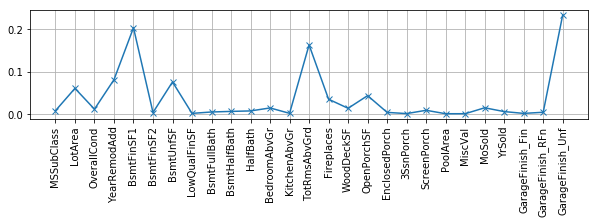

In [434]:
## KEEPOUTPUT
dk = dm2.copy()
dk = dk[[i for i in dm2.columns if not i in ["OverallQual", "GarageCars", "GrLivArea", 
                                             "GarageArea", "YearBuilt", "TotalBsmtSF",
                                            "1stFlrSF", "2ndFlrSF", "FullBath"]]]
X, y, xcols = getXY(dk)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y);
plt.figure(figsize=(10,2)); plt.grid()
plt.plot(rf.feature_importances_, label="est1", marker="x")
plt.xticks(range(len(xcols)), xcols, rotation="vertical");

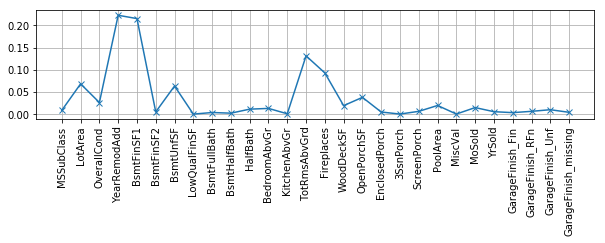

In [435]:
## KEEPOUTPUT
dk = dm1.copy()
dk = dk[[i for i in dm1.columns if not i in ["OverallQual", "GarageCars", "GrLivArea", 
                                             "GarageArea", "YearBuilt", "TotalBsmtSF",
                                            "1stFlrSF", "2ndFlrSF", "FullBath"]]]
X, y, xcols = getXY(dk)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y);
plt.figure(figsize=(10,2)); plt.grid()
plt.plot(rf.feature_importances_, label="est1", marker="x")
plt.xticks(range(len(xcols)), xcols, rotation="vertical");